In [1]:
!pip uninstall pandas
!pip install pandas==1.1.5

Uninstalling pandas-1.2.5:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pandas-1.2.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pandas/*
Proceed (y/n)? n
  Using cached https://files.pythonhosted.org/packages/fd/70/e8eee0cbddf926bf51958c7d6a86bc69167c300fa2ba8e592330a2377d1b/pandas-1.1.5-cp37-cp37m-manylinux1_x86_64.whl
ERROR: pyldavis 3.3.1 has requirement pandas>=1.2.0, but you'll have pandas 1.1.5 which is incompatible.
  Found existing installation: pandas 1.2.5
    Uninstalling pandas-1.2.5:
      Successfully uninstalled pandas-1.2.5


In [2]:
!pip install pyLDAvis 

/home/dibora/miniconda3/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/dibora/miniconda3/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached pyLDAvis-3.3.1.tar.gz (1.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Using cached funcy-1.16-py2.py3-none-any.whl (32 kB)
     |████████████████████            | 9.8 MB 52 kB/s eta 0:01:522^C

ERROR: Operation cancelled by user


In [2]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/dibora/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dibora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import nltk
# import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
from nltk.stem import WordNetLemmatizer 
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pandas as pd
from pprint import pprint
from nltk import corpus
from nltk import wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import string
import os
import re
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
# from clean_tweets_dataframe import Clean_Tweets


/home/dibora/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
#data loader class
class CsvLoader:
    def __init__(self,path,filename):
        self.path = os.path.join(path,filename)

    def load_csv(self):
        df = pd.read_csv(self.path,engine='python',error_bad_lines=False)
        return df


In [7]:
csv_loader = CsvLoader('../Db_files','processed_tweet_data.csv')
csv_loaded = csv_loader.load_csv()
csv_loaded[:10]

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,user_mentions
0,2021-06-18 17:55:49+00:00,"<a href=""http://twitter.com/download/iphone"" r...","Africa is ""in the midst of a full-blown third ...",1.666667e-01,0.188889,en,548.0,612.0,ketuesriche,551,351,"['TelGlobalHealth', 'WHOAFRO']"
1,2021-06-18 17:55:59+00:00,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Dr Moeti is head of WHO in Africa, and one of ...",1.333333e-01,0.455556,en,195.0,92.0,Grid1949,66,92,['globalhlthtwit']
2,2021-06-18 17:56:07+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Thank you research2note for creating this amaz...,3.166667e-01,0.483333,en,2.0,1.0,LeeTomlinson8,1195,1176,"['NHSRDForum', 'Research2note', 'NHSRDForum']"
3,2021-06-18 17:56:10+00:00,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Former Pfizer VP and Virologist, Dr. Michael Y...",8.611111e-02,0.197222,en,1580.0,899.0,RIPNY08,2666,2704,['HighWireTalk']
4,2021-06-18 17:56:20+00:00,"<a href=""http://twitter.com/download/android"" ...",I think its important that we dont sell COVAX ...,2.800000e-01,0.620000,en,72.0,20.0,pash22,28250,30819,['PeterHotez']
5,2021-06-18 17:56:25+00:00,"<a href=""http://twitter.com/download/android"" ...",Im pleased to welcome the WeCanDoThis bus to A...,5.083333e-01,0.783333,en,683.0,220.0,SandhraLee,759,4163,['CDCDirector']
6,2021-06-18 17:56:44+00:00,"<a href=""http://twitter.com/#!/download/ipad"" ...",Yet another amazingly qualified and courageous...,3.700743e-17,0.633333,en,536.0,347.0,neilwalton48,221,599,['RealJoelSmalley']
7,2021-06-18 17:56:46+00:00,"<a href=""http://twitter.com/#!/download/ipad"" ...",Yet another amazingly qualified and courageous...,3.700743e-17,0.633333,en,536.0,348.0,Candide62,154,1102,['RealJoelSmalley']
8,2021-06-18 17:56:46+00:00,"<a href=""http://twitter.com/download/iphone"" r...","Dr Moeti is head of WHO in Africa, and one of ...",1.333333e-01,0.455556,en,197.0,93.0,AnneCar51323293,115,2030,['globalhlthtwit']
9,2021-06-18 17:56:47+00:00,"<a href=""https://mobile.twitter.com"" rel=""nofo...",It is really something to see new research com...,3.727273e-01,0.467424,en,3.0,1.0,DarkaDuna2014,94,144,['LongCovidNYC']


#Data Understanding
Display information on the Data

In [8]:
class DataInfo:
    def __init__(self,df):
        self.df = df

    def general_info(self):
        return self.df.info()

    def general_description(self):
        return self.df.describe()

    def count_null(self):
        return self.df.isnull().sum()

In [9]:
Get_Info = DataInfo(csv_loaded)
print(Get_Info.general_info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3720 entries, 0 to 3719
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   created_at       3720 non-null   object 
 1   source           3720 non-null   object 
 2   original_text    3720 non-null   object 
 3   polarity         3720 non-null   float64
 4   subjectivity     3720 non-null   float64
 5   lang             3720 non-null   object 
 6   favorite_count   3720 non-null   float64
 7   retweet_count    3720 non-null   float64
 8   original_author  3720 non-null   object 
 9   followers_count  3720 non-null   int64  
 10  friends_count    3720 non-null   int64  
 11  user_mentions    3720 non-null   object 
dtypes: float64(4), int64(2), object(6)
memory usage: 348.9+ KB
None


In [10]:
print(Get_Info.general_description())

          polarity  subjectivity  favorite_count  retweet_count  \
count  3720.000000   3720.000000     3720.000000    3720.000000   
mean      0.145035      0.445425      318.519355     135.228495   
std       0.210508      0.218848      741.445959     261.795796   
min      -1.000000      0.000000        0.000000       1.000000   
25%       0.000000      0.288221       11.000000       6.000000   
50%       0.136364      0.450000       94.000000      39.000000   
75%       0.278571      0.613636      416.000000     151.000000   
max       1.000000      1.000000    20527.000000    6847.000000   

       followers_count  friends_count  
count     3.720000e+03    3720.000000  
mean      9.375893e+03    2212.945968  
std       2.291726e+05    6351.014588  
min       0.000000e+00       0.000000  
25%       1.437500e+02     284.500000  
50%       5.940000e+02     834.500000  
75%       2.103750e+03    2418.000000  
max       1.366658e+07  237298.000000  


In [11]:
print(Get_Info.count_null())

created_at         0
source             0
original_text      0
polarity           0
subjectivity       0
lang               0
favorite_count     0
retweet_count      0
original_author    0
followers_count    0
friends_count      0
user_mentions      0
dtype: int64


In [12]:
import pandas as pd


class Clean_Tweets:
    """
    The PEP8 Standard AMAZING!!!
    """
    def __init__(self, df:pd.DataFrame):
        self.df = df
        print('Automation in Action...!!!')

    def drop_duplicate(self)->pd.DataFrame:
        """
        drop duplicate rows
        """        
        return self.df.drop_duplicates()

    def convert_to_datetime(self,df)->pd.DataFrame:
        """
        convert column to datetime
        """
        df['created_at'] = pd.to_datetime(self.df['created_at'])
        return df
    
    def convert_to_numbers(self, df:pd.DataFrame)->pd.DataFrame:
        """
        convert columns like polarity, subjectivity, retweet_count
        favorite_count etc to numbers
        """
        df['polarity'] = pd.to_numeric(self.df['polarity'])
        df['subjectivity'] = pd.to_numeric(self.df['subjectivity'])
        df['retweet_count'] = pd.to_numeric(self.df['retweet_count'])
        df['favorite_count'] = pd.to_numeric(self.df['favorite_count'])
        df['followers_count'] = pd.to_numeric(self.df['followers_count'])
        return df

    def drop_null_col(self, df:pd.DataFrame)->pd.DataFrame:
        # removed columns containing null values of more than 20%
        row,col = df.shape
        df.dropna(axis='columns',thresh=row*0.8,inplace=True)
        print(df.columns)
        return df
        

    def special_chars(self,x):
        special_characters = '@_!#$%^&*()<>?/\|}{~:;[]'
        for char in special_characters:
            x = x.replace(char, '')
        x = x.encode('ascii', 'ignore').decode('ascii')
        return x

    def filter_text(self,df:pd.DataFrame) ->pd.DataFrame:
        df['clean_text'] = self.df['original_text'].apply(lambda x: self.special_chars(x))
        # print(df['original_text'])
        return df

    def clean_dataframe(self):
        df_duplicatedropped = self.drop_duplicate()
        df_datetime = self.convert_to_datetime(df_duplicatedropped)
        df_numb =  self.convert_to_numbers(df_datetime)
        df_nulldroped = self.drop_null_col(df_numb)
        df_cleaned = self.filter_text(df_nulldroped)
        return df_cleaned
    

In [13]:
  cleanData = Clean_Tweets(csv_loaded).clean_dataframe()

Automation in Action...!!!
Index(['created_at', 'source', 'original_text', 'polarity', 'subjectivity',
       'lang', 'favorite_count', 'retweet_count', 'original_author',
       'followers_count', 'friends_count', 'user_mentions'],
      dtype='object')


#Data Preparation
Select and clean the data we are going to use for our model

In [16]:
class PreparedData:
    def __init__(self,df):
        self.df = df

    def select_data(self):
        df_en = self.df[self.df.lang == "en"]
        sel_df = df_en['original_text']
        sentence_list = sel_df.tolist()
        return sentence_list

    def tokenize_data(self,sentence_list):
    #creating sentences and words from the input tweets
        words = []
        for sent in sentence_list:
            for myWord in sent.split():
                words.append(myWord.lower())   
        return words 

    def lemmatize_data(self,word):
        wl = WordNetLemmatizer()
        return str(wl.lemmatize(word))

    def remove_stop_words(self,word):
        s_words = stopwords.words('english')
        if word not in s_words:
            return word

    def remove_none(self,wordlist):
        cleaned_list = []
        for w in wordlist:
            if w is not None:
                cleaned_list.append(w)
        return cleaned_list

    def prepare_data(self):
    # PreparedData_object = PreparedData(self.df)
        prepared_sentencelist = self.select_data()
        word_list = self.tokenize_data(prepared_sentencelist)
        prepared = [self.remove_stop_words(self.lemmatize_data(word)) for word in word_list]
        prepared_wordList = self.remove_none(prepared)
        word_id = corpora.Dictionary([prepared_wordList])
        myCorpus = [word_id.doc2bow(prepared_word) for prepared_word in [prepared_wordList]]
        return prepared_sentencelist,prepared_wordList,word_id,myCorpus  



In [17]:
prepared_sentencelist,prepared_wordlist,word_id,myCorpus = PreparedData(csv_loaded).prepare_data()

In [18]:
prepared_wordlist[:10]

['africa',
 '"in',
 'midst',
 'full-blown',
 'third',
 'wave"',
 'coronavirus,',
 'head',
 'whoafro',
 'ha']

#Modeling
Selecting the right model and assessing it 

In [23]:
class Modeling:
    def __init__(self,prepared_sentencelist,prepared_wordlist,word_id,myCorpus):
        self.wordList = prepared_wordlist
        self.word_id = word_id
        self.corpus = myCorpus
        self.sentencelist = prepared_sentencelist
  
    def LDA_model(self,num_topics = 4,chunksize=100,passes=10,alpha='auto'):
        return gensim.models.ldamodel.LdaModel(self.corpus,
                                           id2word=self.word_id,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=chunksize,
                                           passes=passes,
                                           alpha=alpha,
                                           per_word_topics=True)
    def word_cloud(self):
        text =""
        for sentence in self.sentencelist:
            text += sentence
        wordcloud = WordCloud().generate(text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
    
    def display_info_model(self,model):
        pprint(model.show_topics(formatted=False))


In [24]:
Model = Modeling(prepared_sentencelist,prepared_wordlist,word_id,myCorpus)
ldaModel = Model.LDA_model(num_topics = 5,chunksize=80,passes=10,alpha=100)
Model.display_info_model(ldaModel)

[(0,
  [('vaccine', 0.018042708),
   ('covid19', 0.012308004),
   ('amp', 0.005219389),
   ('need', 0.0039911964),
   ('health', 0.0038388225),
   ('ha', 0.0036159367),
   ('one', 0.003202691),
   ('case', 0.0030695228),
   ('africa', 0.0026498428),
   ('third', 0.0026109947)]),
 (1,
  [('vaccine', 0.00928199),
   ('covid19', 0.0052526356),
   ('amp', 0.001798532),
   ('case', 0.0017298455),
   ('health', 0.0016578872),
   ('need', 0.0016467071),
   ('third', 0.0014877602),
   ('ha', 0.0013918846),
   ('one', 0.0012934061),
   ('vaccines.', 0.0012805305)]),
 (2,
  [('vaccine', 0.002409199),
   ('covid19', 0.002306293),
   ('health', 0.000993479),
   ('ha', 0.00085674226),
   ('need', 0.0007742199),
   ('amp', 0.0007530604),
   ('dos', 0.0007005627),
   ('africa', 0.00068328436),
   ('case', 0.00063618616),
   ('today', 0.00058545545)]),
 (3,
  [('covid19', 0.005600311),
   ('vaccine', 0.0055156043),
   ('amp', 0.0017580006),
   ('case', 0.0014284169),
   ('need', 0.0014256289),
   ('do

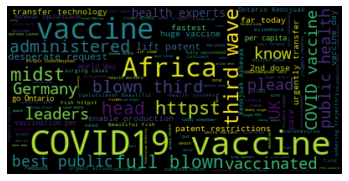

In [27]:
Model.word_cloud()

In [32]:
# Evaluation using coherence
class evaluation:
    def __init__(self,model,prepared_wordlist,word_id):
        self.model = model
        self.prepared_wordlist = prepared_wordlist
        self.word_id = word_id

    def coherence_eval(self):
        lda_coherence_mod = CoherenceModel(model=self.model, texts=[self.prepared_wordlist], dictionary=self.word_id, coherence='c_v')
        coherence = lda_coherence_mod.get_coherence()
        print(f'Coherence score and accuracy {coherence}', )

In [33]:
evaluation(ldaModel,prepared_wordlist,word_id).coherence_eval()

Coherence score and accuracy 0.2649209804865912


Visualization

In [35]:
#Visualizing
# pyLDAvis.enable_notebook()
# LDAvis_prepared = gensimvis.prepare(ldaModel, myCorpus, word_id)
# LDAvis_prepared